### Esercitazione 21 - Chaikin Money Flow (CMF)
#### Argomenti

* indicatore CMF
* creazione di grafici custom per il CMF
* implementazione di una semplice strategia basata sul CMF

Chaikin Money Flow (CMF) è una media ponderata per il volume di accumulazione e distribuzione in un periodo
specificato. Il periodo standard per CMF è di 21 giorni.
Il principio alla base del CMF è che più il prezzo di chiusura è vicino al massimo, maggiore è l'accumulo.
Al contrario, più il prezzo di chiusura è vicino al minimo, maggiore è la distribuzione.
Se il prezzo si chiude costantemente al di sopra del punto medio della barra all'aumentare del volume, il CMF
sarà positivo, al contrario, se il prezzo si chiude costantemente al di sotto del punto medio della barra
all'aumentare del volume, il CMF avrà un valore negativo.

Si calcola seguendo la formula, che ricorda l'indicatore ADL eccetto per il calcolo finale che normalizza il
Money Flow Volume sui volumi scambiati nel periodo considerato:

Money Flow Multiplier = [(Close  -  Low) - (High - Close)] / (High - Low)     
Money Flow Volume = Money Flow Multiplier x Volume      
CMF su n periodi = somma su n periodi di Money Flow Volume / somma su n periodi di Volume      

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import talib
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from collections import deque
import numpy as np

In [2]:
connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_D1, 0, 90))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

In [3]:
# calcolo del CMF

periodi = 14

candles['mfm'] = ((candles.close - candles.low) - (candles.high - candles.close)) / (candles.high - candles.low)
candles['mfv'] = candles.mfm * candles.tick_volume
candles['cmf'] = candles.mfv.rolling(window=periodi).sum() / candles.tick_volume.rolling(window=periodi).sum()

candles = candles[periodi:]

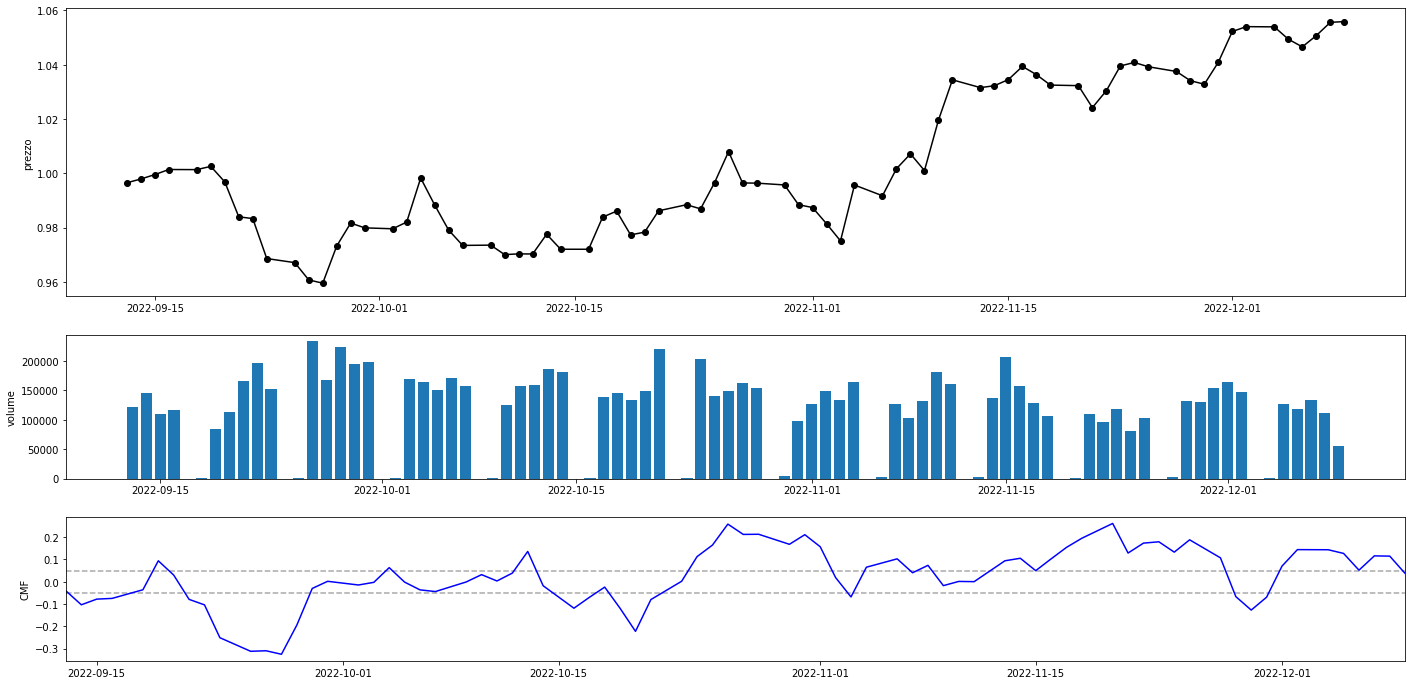

In [4]:
# visualizzazione del CMF su un grafico

fig, (ax_price, ax_vol, ax_cmf) = plt.subplots(3, figsize=(24, 12), gridspec_kw={'height_ratios': [2, 1, 1]})

ax_price.plot(candles.index, candles['close'], color='black')
ax_price.scatter(candles.index, candles['close'], color='black', marker='o')
ax_price.set_ylabel('prezzo')
plt.autoscale(True, axis='x', tight=True)

ax_vol.bar(candles.index, candles.tick_volume, width=0.8)
ax_vol.set_ylabel('volume')

# normalmente vengono tracciate due bande a -0.05 e +0.05 del CMF come
# soglie per filtrare eventuali ritracciamenti intorno allo zero
ax_cmf.hlines(-0.05, candles.index[0], candles.index[-1], linestyle='--', color='darkgray')
ax_cmf.hlines(0.05, candles.index[0], candles.index[-1], linestyle='--', color='darkgray')

ax_cmf.plot(candles.index, candles['cmf'], color='blue')
ax_cmf.set_ylabel('CMF')

plt.show()

In [5]:
# recupero di un dataset più corposo per testare una strategia che sfrutti
# medie mobili esponenziali del prezzo e l'indicatore CMF

connected = mt5.initialize(login=5798528, server="ActivTrades-Server", password='QFPHrdgg')

if connected:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_D1, 0, 500))
    mt5.shutdown()
else:
    print('MT5 account error.')

candles['time'] = pd.to_datetime(candles['time'], unit='s')
candles.set_index('time', inplace=True)

periodi = 5

candles['mfm'] = ((candles.close - candles.low) - (candles.high - candles.close)) / (candles.high - candles.low)
candles['mfv'] = candles.mfm * candles.tick_volume
candles['cmf'] = candles.mfv.rolling(window=periodi).sum() / candles.tick_volume.rolling(window=periodi).sum()
candles['ema'] = talib.EMA(candles.close, timeperiod=periodi)

candles = candles[periodi:]

In [7]:
# implementazione e test di una strategia basata su EMA del prezzo e CMF

posizione = 0
performance = 0.
vinte = 0
perse = 0

for i in range(len(candles)):
    c = candles.iloc[i]
    if posizione == 0:
        if c.close > c.ema and c.cmf > 0.2:
            posizione = 1
            prezzo_iniziale = c.close
        if c.close < c.ema and c.cmf < -0.2:
            posizione = -1
            prezzo_iniziale = c.close
    elif posizione == 1:
        if c.close < c.ema and c.cmf < -0.2:
            posizione = 0
            risultato = prezzo_iniziale - c.close
            if risultato > 0:
                vinte += 1
            else:
                perse += 1
            performance += risultato
    else:
        if c.close > c.ema and c.cmf > 0.2:
            posizione = 0
            risultato = prezzo_iniziale - c.close
            if risultato > 0:
                vinte += 1
            else:
                perse += 1
            performance += risultato

print('performance:', performance, '- vinte', vinte, '/', vinte + perse)

performance: 0.1475000000000004 - vinte 20 / 32
